In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


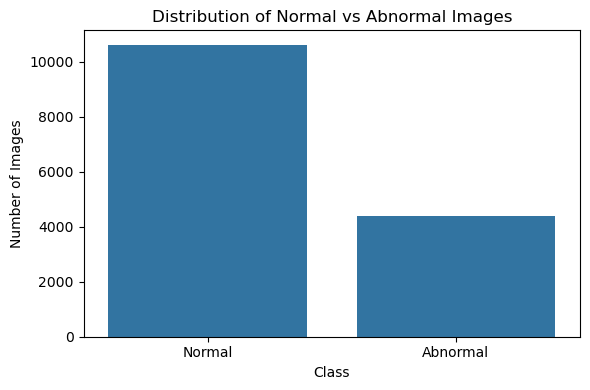

In [2]:
import pandas as pd

# Define base directory where dataset is stored
BASE_DIR = "/scratch"

# Load the dataset CSV file
train_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

# Mark images as abnormal if any class is not "No finding"
train_df["abnormal"] = train_df["class_name"] != "No finding"

# Create binary labels per image
binary_labels_df = train_df.groupby("image_id")["abnormal"].any().reset_index()
binary_labels_df["label"] = binary_labels_df["abnormal"].astype(int)

# Plot distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=binary_labels_df)
plt.xticks([0, 1], ["Normal", "Abnormal"])
plt.title("Distribution of Normal vs Abnormal Images")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [3]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and prepare dataset
BASE_DIR = "/scratch"
train_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
train_df["binary_label"] = (train_df["class_name"] != "No finding").astype(int)
label_df = train_df.groupby("image_id")["binary_label"].max().reset_index()

# Split dataset
train_ids = label_df["image_id"].values
train_labels = label_df["binary_label"].values.astype("float32")
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_ids, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Dataset class
class ChestXrayBinaryDataset(Dataset):
    def __init__(self, image_ids, labels, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(BASE_DIR, "train", f"{img_id}.dicom")
        dicom = pydicom.dcmread(img_path)
        img = dicom.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        img = np.stack([img] * 3, axis=-1)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

# Dataloaders
train_dataset = ChestXrayBinaryDataset(train_ids, train_labels, transform=transform)
val_dataset = ChestXrayBinaryDataset(val_ids, val_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=6)

# Model
class BinaryXrayModel(nn.Module):
    def __init__(self):
        super(BinaryXrayModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, 1)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = BinaryXrayModel().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/sit

In [ ]:
# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return val_loss / len(loader), accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds)

# Train loop
EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
    scheduler.step(val_f1)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

# Save model
os.makedirs("model_output", exist_ok=True)
torch.save(model.state_dict(), "model_output/bin_xray_weights.pt")

In [ ]:
torch.save(model.state_dict(), "model_output/bin_xray_weights.pt")

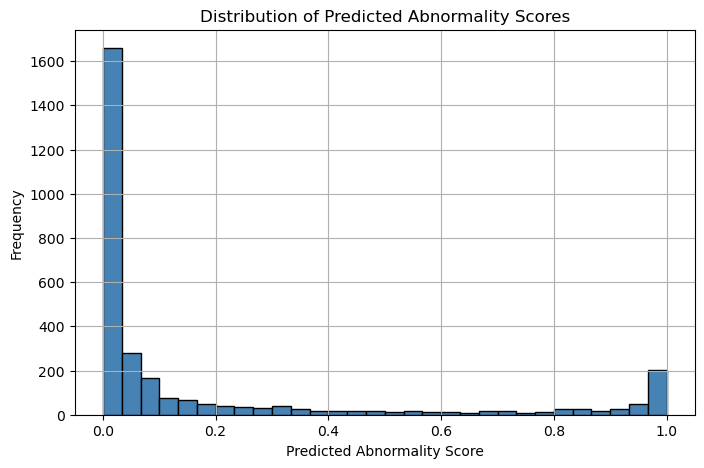

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import shap
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
from PIL import Image
from glob import glob
import os

# ----- Step 1: Load Binary Model -----
class BinaryXrayModel(nn.Module):
    def __init__(self):
        super(BinaryXrayModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, 1)  # Binary output

    def forward(self, x):
        return torch.sigmoid(self.model(x))  # Output in range [0, 1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryXrayModel().to(device)
model.load_state_dict(torch.load("model_output/bin_xray_weights.pt", map_location=device))
model.eval()

# ----- Step 2: Image Preprocessing -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_dicom_image(path):
    dicom = dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min()) * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = Image.fromarray(img).convert("RGB")
    return transform(img)

test_images = sorted(glob("/scratch/test/*.dicom"))
input_tensor = torch.stack([load_dicom_image(p) for p in test_images])
input_numpy = input_tensor.permute(0, 2, 3, 1).numpy()  # (N, H, W, C), keep float

# ----- Step 3a: Get abnormality scores -----
abnormality_scores = []
with torch.no_grad():
    for path in test_images:
        img_tensor = load_dicom_image(path).unsqueeze(0).to(device)  # (1, 3, 224, 224)
        score = model(img_tensor).item()
        abnormality_scores.append(score)

# ----- Step 3b: Plot histogram of abnormality scores -----
plt.figure(figsize=(8, 5))
plt.hist(abnormality_scores, bins=30, color="steelblue", edgecolor="black")
plt.xlabel("Predicted Abnormality Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Abnormality Scores")
plt.grid(True)
plt.show()


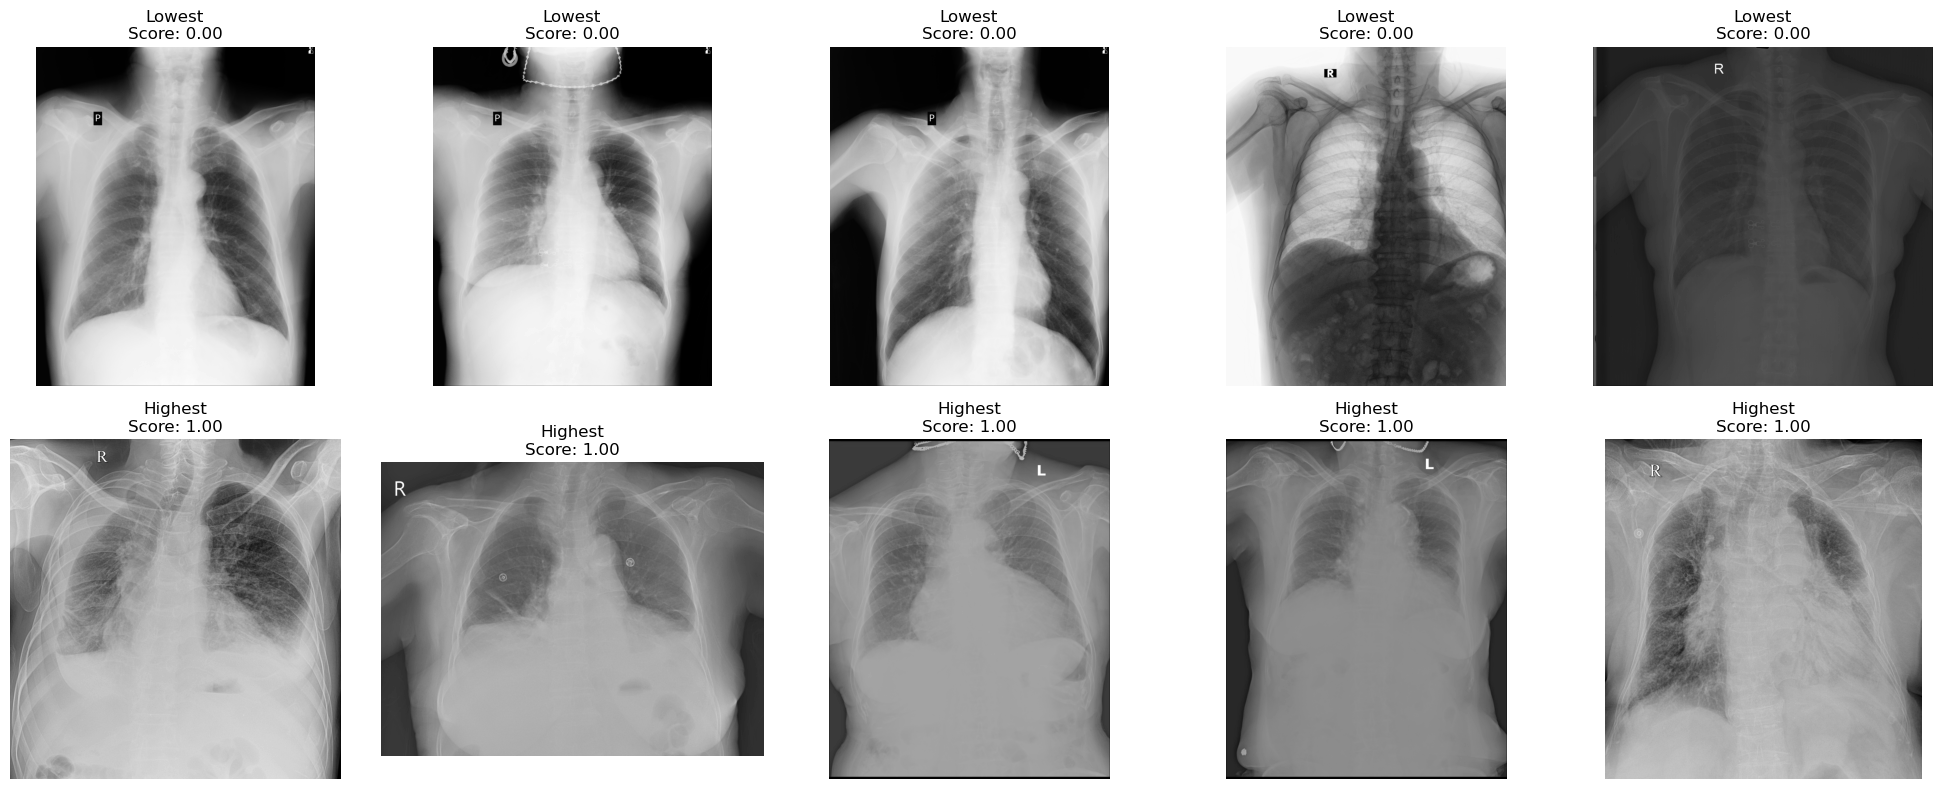

[1570  895  589 2439 2324 2186 2918  363 1018 2397]
[3.1719438993604854e-05, 4.197497764835134e-05, 4.4432126742322e-05, 6.200648931553587e-05, 6.604049121960998e-05, 0.9999833106994629, 0.9999843835830688, 0.9999902248382568, 0.9999920129776001, 0.9999996423721313]


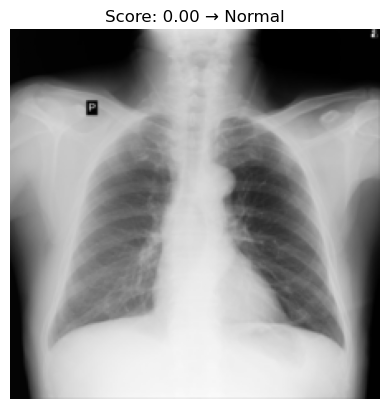

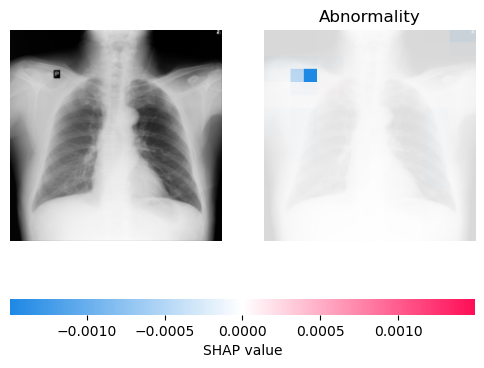

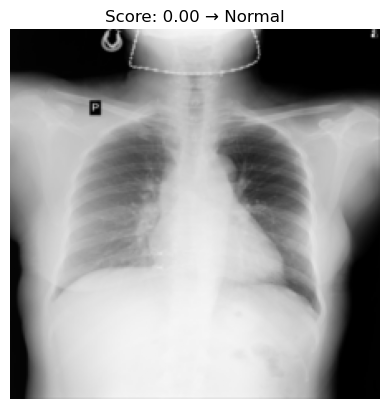

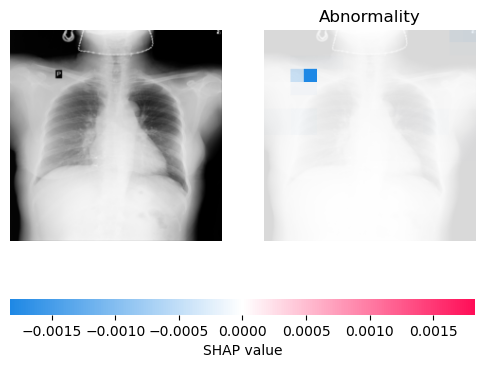

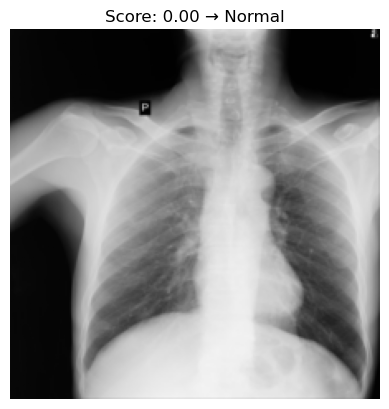

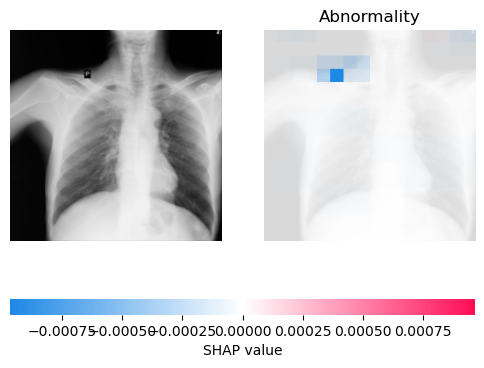

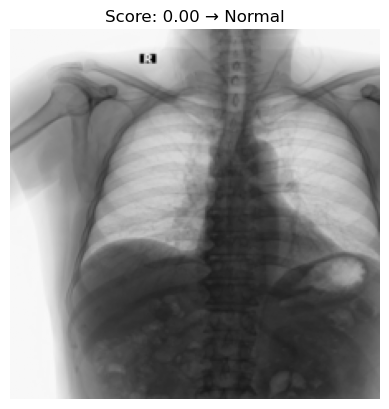

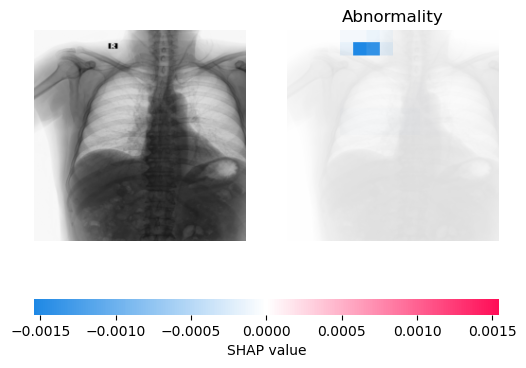

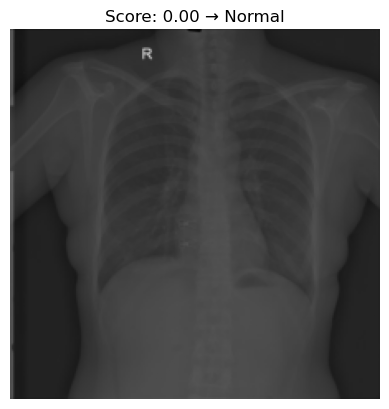

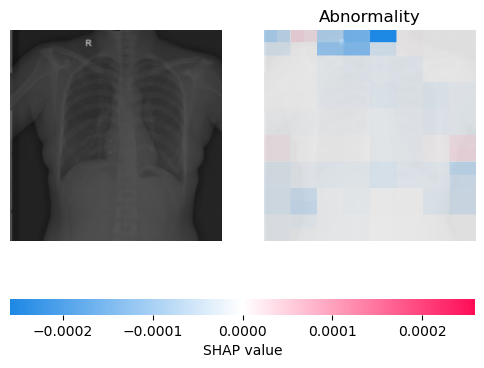

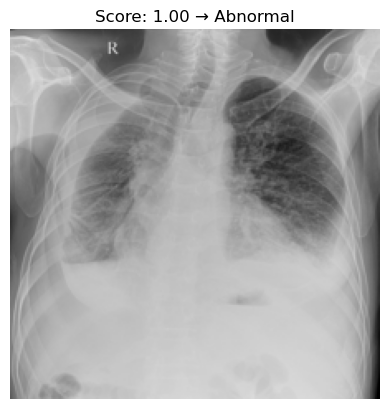

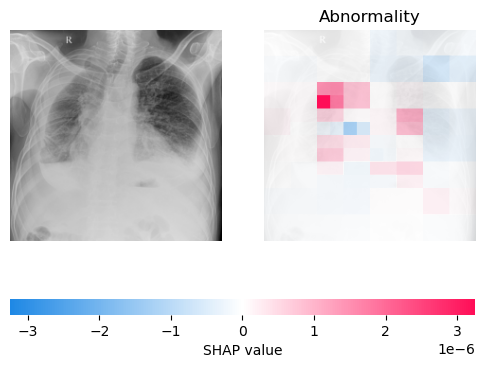

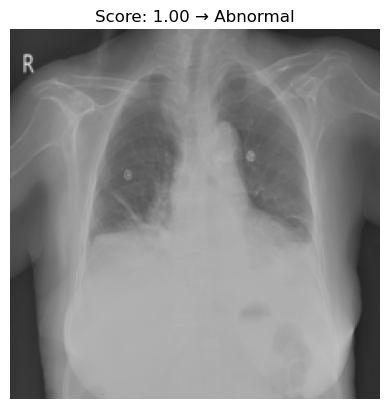

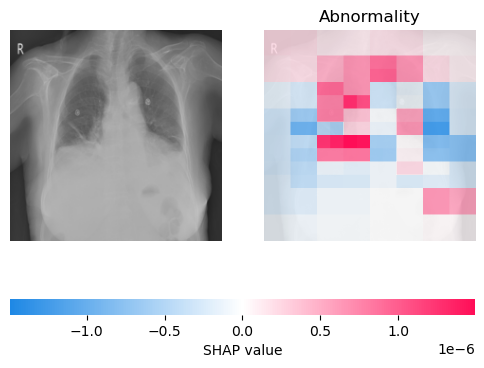

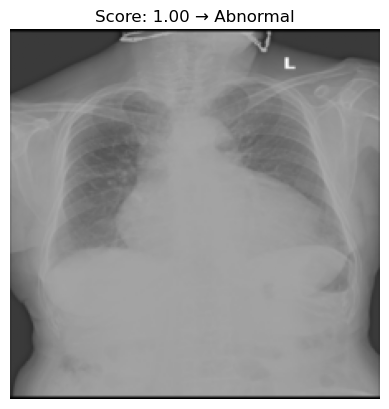

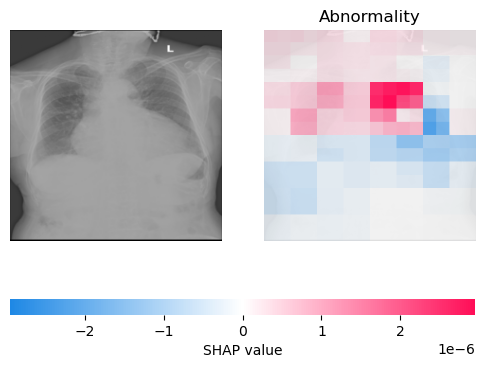

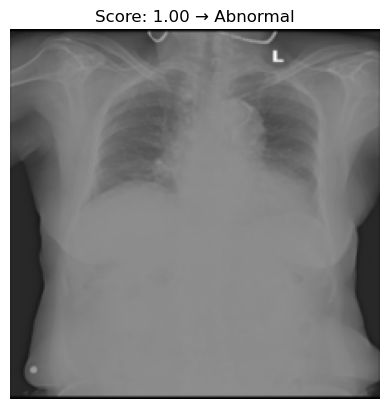

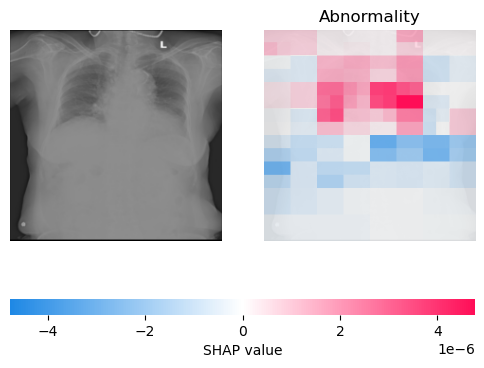

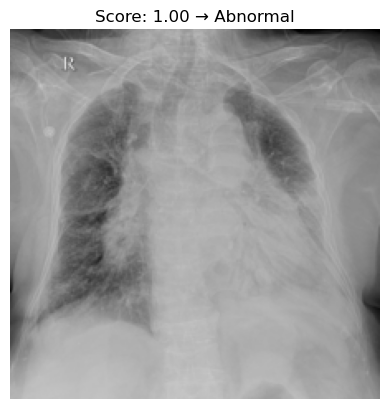

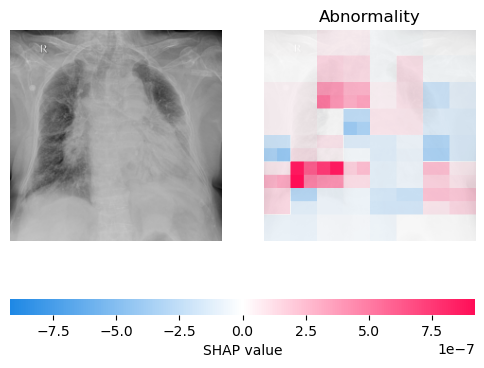

'\nfor i in selected_indices:\n    #img = input_numpy[i:i+1]\n    img_tensor = load_dicom_image(test_paths[i])\n    img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  # (224, 224, 3)\n    img = img_numpy[np.newaxis, ...]\n    # Predict abnormality probability\n    prob = f(img)[0][0]\n    \n    # Show image and prediction\n    plt.imshow(img[0])\n    plt.axis(\'off\')\n    plt.title(f"Score: {prob:.2f} → {\'Abnormal\' if prob > 0.5 else \'Normal\'}")\n    plt.show()\n    \n    # SHAP explanation\n    shap_values = explainer(img, max_evals=500, batch_size=1)\n    shap.image_plot(shap_values)\n'

In [19]:
# ----- Step 4: Prediction Function -----
def f(X):
    X_tensor = torch.tensor(X).permute(0, 3, 1, 2).float().to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()
    return preds

# ----- Step 5: SHAP Explanation -----
#masker = shap.maskers.Image("inpaint_telea", input_numpy[0].shape)
masker = shap.maskers.Image("blur(128,128)", input_numpy[0].shape)

explainer = shap.Explainer(f, masker, output_names=["Abnormality"])
# Sort image paths by their associated abnormality scores
sorted_indices = np.argsort(abnormality_scores)
bottom_5_indices = sorted_indices[:5]
top_5_indices = sorted_indices[-5:]

# Combine paths and scores
selected_indices = np.concatenate([bottom_5_indices, top_5_indices])
selected_paths = [test_images[i] for i in selected_indices]
selected_scores = [abnormality_scores[i] for i in selected_indices]
titles = ["Lowest"]*5 + ["Highest"]*5

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for ax, path, score, title in zip(axes.flat, selected_paths, selected_scores, titles):
    dicom = dcmread(path)
    img = dicom.pixel_array
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{title}\nScore: {score:.2f}", fontsize=12)

plt.tight_layout()
plt.show()

print(selected_indices)
print(selected_scores)


# ----- SHAP Loop for Selected Images -----
for path, score in zip(selected_paths, selected_scores):
    # Load and preprocess image
    img_tensor = load_dicom_image(path)  # shape: (3, 224, 224)
    img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  # shape: (224, 224, 3)
    img = img_numpy[np.newaxis, ...]  # Add batch dimension: (1, 224, 224, 3)
    
    # Predict abnormality probability
    prob = f(img)[0][0]
    
    # Show image and prediction
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(f"Score: {prob:.2f} → {'Abnormal' if prob > 0.5 else 'Normal'}")
    plt.show()
    
    # SHAP partition explanation
    shap_values = explainer(img, max_evals=500, batch_size=1)
    shap.image_plot(shap_values)


In [ ]:

# ----- Load full test set -----
test_paths = sorted(glob("/scratch/test/*.dicom"))
print(f"Loaded {len(test_paths)} test images.")

# ----- Batch load and predict -----
abnormality_scores = []
print(len(abnormality_scores))
with torch.no_grad():
    for path in test_paths:
        img_tensor = load_dicom_image(path).unsqueeze(0).to(device)  # (1, 3, 224, 224)
        score = model(img_tensor).item()
        abnormality_scores.append(score)

# ----- Plot histogram of abnormality scores -----
plt.figure(figsize=(8, 5))
plt.hist(abnormality_scores, bins=30, color="steelblue", edgecolor="black")
plt.xlabel("Predicted Abnormality Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Abnormality Scores")
plt.grid(True)
plt.show()

In [ ]:
# Sort image paths by their associated abnormality scores
sorted_indices = np.argsort(abnormality_scores)
bottom_5_indices = sorted_indices[:5]
top_5_indices = sorted_indices[-5:]

# Combine paths and scores
selected_indices = np.concatenate([bottom_5_indices, top_5_indices])
selected_paths = [test_paths[i] for i in selected_indices]
selected_scores = [abnormality_scores[i] for i in selected_indices]
titles = ["Lowest"]*5 + ["Highest"]*5

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for ax, path, score, title in zip(axes.flat, selected_paths, selected_scores, titles):
    dicom = dcmread(path)
    img = dicom.pixel_array
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{title}\nScore: {score:.2f}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Loop over selected images and plot SHAP explanations
for i in selected_indices:
    img_tensor = load_dicom_image(test_paths[i])  # shape: (3, 224, 224)
    img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  # shape: (224, 224, 3)

    # Predict and explain
    shap_values = explainer(img_numpy[np.newaxis, ...], max_evals=500, batch_size=1)
    
    # Visualize SHAP
    print(f"Score: {score:.2f} → {'Abnormal' if score > 0.5 else 'Normal'}")
    shap.image_plot(shap_values)